In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import pickle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp '/content/drive/MyDrive/All Projects/TraumaChat/dataset_v2.xlsx' -d '/content/'

In [5]:
df = pd.read_excel('dataset_v2.xlsx')
df.head()

,Sno,Text,Category
0,1,I've been feeling overwhelmed lately with work...,Trauma
1,2,Life has been quite stressful for me recently....,Trauma
2,3,I've been enjoying some quality time with fami...,Non-Trauma
3,4,I've been feeling anxious and restless lately....,Trauma
4,5,I'm grateful for the support system I have. It...,Non-Trauma


In [6]:
df.columns

Index(['Sno', 'Text', 'Category'], dtype='object')

In [7]:
df['Category'].value_counts()

Trauma        102
Non-Trauma     98
Name: Category, dtype: int64

In [12]:
import plotly.graph_objects as go

# Extracting data
sentiment_labels = df['Category'].value_counts().index
sentiment_values = df['Category'].value_counts().values

# Creating a figure with differently styled bars
plot_figure = go.Figure(data=[
    go.Bar(x=sentiment_labels, y=sentiment_values,
           marker_color='rgba(55, 128, 191, 0.7)',
           marker_line_color='rgba(55, 128, 191, 1.0)',
           marker_line_width=2, opacity=0.6)
])

# Updating the layout
plot_figure.update_layout(
    title_text="Sentiments Overview",
    xaxis=dict(title="Sentiment Types", showgrid=False),
    yaxis=dict(title="Count", showgrid=False),
    plot_bgcolor='rgba(240, 240, 240, 0.95)',
    paper_bgcolor='rgba(245, 245, 245, 1)'
)

# Display the modified plot
plot_figure.show()


In [11]:
dataset = df
dataset['Label'] = dataset.Category.replace({'Trauma': 1, 'Non-Trauma': 0})
selected_data = dataset[["Text", "Label"]]
sample_data = selected_data.head(1000)
sample_data.shape


(200, 2)

#Cleaning Text

In [17]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [18]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import WordNetLemmatizer
import string

nlp_processor = spacy.load('en_core_web_sm')
lemmatizer_tool = WordNetLemmatizer()

def preprocess_text(input_text):
    filtered_words = []

    processed_text = nlp_processor(input_text)
    named_entities = {ent.text for ent in processed_text.ents}

    for token in processed_text:
        if token.text not in named_entities:
            filtered_words.append(token.text)
    clean_text = " ".join(filtered_words)

    # Further text preprocessing
    clean_text = clean_text.lower().strip()
    clean_text = clean_text.replace("</br>", " ")
    clean_text = clean_text.replace("-", " ")
    clean_text = "".join([char for char in clean_text if char not in string.punctuation and not char.isdigit()])
    clean_text = " ".join([word for word in clean_text.split() if word not in STOP_WORDS])
    clean_text = "".join([lemmatizer_tool.lemmatize(word) for word in clean_text])

    return clean_text

dataset['Text'] = dataset['Text'].apply(preprocess_text)
dataset.head()

,Sno,Text,Category,Label
0,1,ve feeling overwhelmed lately work personal is...,Trauma,1
1,2,life stressful recently m having trouble findi...,Trauma,1
2,3,ve enjoying quality time family friends s refr...,Non-Trauma,0
3,4,ve feeling anxious restless lately nt calm mind,Trauma,1
4,5,m grateful support system helps navigate tough...,Non-Trauma,0


#TFID

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = dataset['Text'].tolist()
vectorizer = TfidfVectorizer(max_df=0.85, max_features=20000)
transformed_docs = vectorizer.fit_transform(corpus)
corpus_array = transformed_docs.toarray()
X, y = corpus_array, dataset['Category']

In [22]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
X_training, X_validation, y_training, y_validation = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

print("Training data dimensions:", X_training.shape, y_training.shape)
print("Validation data dimensions:", X_validation.shape, y_validation.shape)


Training data dimensions: (150, 316) (150,)
Validation data dimensions: (50, 316) (50,)


#Multinominal Naive Bayes

In [28]:
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Model Training and Predictions
classifier = MultinomialNB()
classifier.fit(X_training, y_training)

train_predictions = classifier.predict(X_training)
test_predictions = classifier.predict(X_validation)

# Accuracy scores
print("\nTrain Accuracy:", accuracy_score(y_training, train_predictions))
print("Test Accuracy:", accuracy_score(y_validation, test_predictions))

# Classification report
print(classification_report(y_validation, test_predictions, target_names=['Non-Trauma', 'Trauma']))



Train Accuracy: 1.0
Test Accuracy: 1.0
              precision    recall  f1-score   support

  Non-Trauma       1.00      1.00      1.00        25
      Trauma       1.00      1.00      1.00        25

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



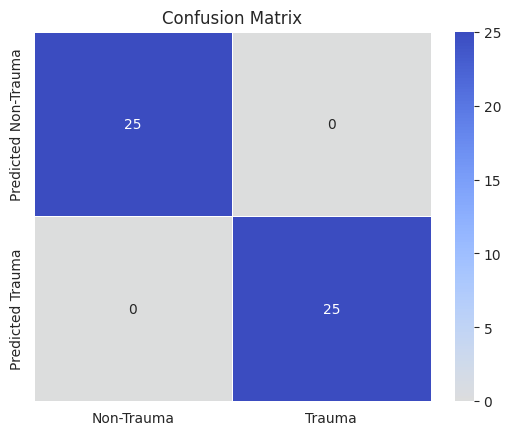

In [27]:

#Confusion Matrix visualization
matrix = confusion_matrix(y_validation, test_predictions)
matrix_df = pd.DataFrame(matrix, columns=['Non-Trauma', 'Trauma'],
                         index=['Predicted Non-Trauma', 'Predicted Trauma'])

sns.heatmap(matrix_df, annot=True, fmt='g', cmap='coolwarm_r', center=0, linewidths=.5)
plt.title('Confusion Matrix')
plt.show()

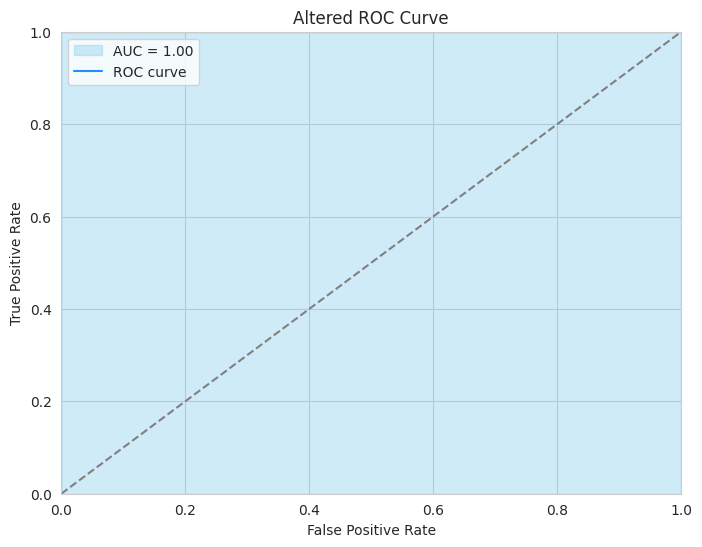

In [29]:
# ROC Curve with a different style using filled areas

y_validation_binary = y_validation.map({'Non-Trauma': 0, 'Trauma': 1})

probabilities = classifier.predict_proba(X_validation)
scores = probabilities[:, 1]
fpr_vals, tpr_vals, _ = roc_curve(y_validation_binary, scores)
area_under_curve = auc(fpr_vals, tpr_vals)


sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
plt.fill_between(fpr_vals, tpr_vals, color='skyblue', alpha=0.4, label='AUC = {:.2f}'.format(area_under_curve))
plt.plot(fpr_vals, tpr_vals, color='dodgerblue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Altered ROC Curve')
plt.legend(loc="best")
plt.show()

#Decision Tree Classifier

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the Decision Tree
tree_classifier = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_classifier.fit(X_training, y_training)

# Predictions
predictions_train = tree_classifier.predict(X_training)
predictions_test = tree_classifier.predict(X_validation)

# Display accuracy results
print("Train Accuracy: {:.2f}%".format(accuracy_score(y_training, predictions_train)))
print("Test Accuracy: {:.2f}%".format(accuracy_score(y_validation, predictions_test)))

# Classification report
print(classification_report(y_validation, predictions_test, target_names=['Non-Trauma', 'Trauma']))


Train Accuracy: 1.00%
Test Accuracy: 1.00%
              precision    recall  f1-score   support

  Non-Trauma       1.00      1.00      1.00        25
      Trauma       1.00      1.00      1.00        25

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



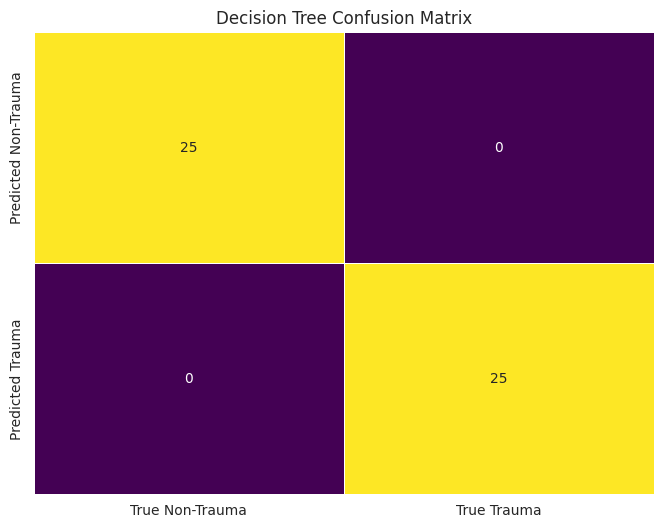

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the confusion matrix to a DataFrame
matrix = confusion_matrix(y_validation, predictions_test)
cm_dataframe = pd.DataFrame(
    matrix,
    columns=['True Non-Trauma', 'True Trauma'],
    index=['Predicted Non-Trauma', 'Predicted Trauma']
)

# Visualize using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dataframe, annot=True, fmt='d', cmap='viridis', linewidths=0.5, cbar=False)
plt.title('Decision Tree Confusion Matrix')
plt.show()


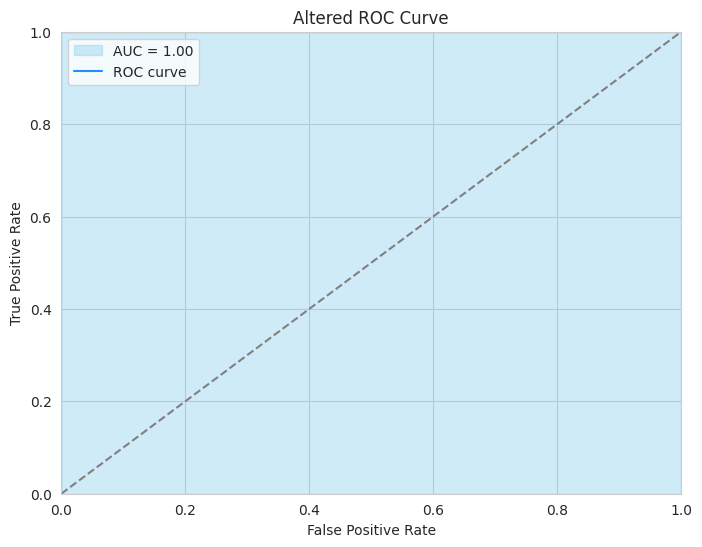

In [37]:
# ROC Curve with a different style using filled areas

y_validation_binary = y_validation.map({'Non-Trauma': 0, 'Trauma': 1})

probabilities = tree_classifier.predict_proba(X_validation)
scores = probabilities[:, 1]
fpr_vals, tpr_vals, _ = roc_curve(y_validation_binary, scores)
area_under_curve = auc(fpr_vals, tpr_vals)


sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
plt.fill_between(fpr_vals, tpr_vals, color='skyblue', alpha=0.4, label='AUC = {:.2f}'.format(area_under_curve))
plt.plot(fpr_vals, tpr_vals, color='dodgerblue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Altered ROC Curve')
plt.legend(loc="best")
plt.show()

# Naive Bayes and Tree Ensemble Model

In [35]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Define the individual classifiers
classifier_list = [
    ('Decision Tree', tree_classifier),
    ('Naive Bayes', classifier)
]

# Initialize the Voting Classifier
vote_classifier = VotingClassifier(estimators=classifier_list)

# Train the Voting Classifier on the training data
vote_classifier.fit(X_training, y_training)

# Make predictions
train_predictions = vote_classifier.predict(X_training)
test_predictions = vote_classifier.predict(X_validation)

# Display the accuracy scores
print("Train Accuracy: {:.2f}%".format(100 * accuracy_score(y_training, train_predictions)))
print("Test Accuracy: {:.2f}%".format(100 * accuracy_score(y_validation, test_predictions)))


Train Accuracy: 100.00%
Test Accuracy: 100.00%
